# Chapter 6 학습 관련 기술들
1. 최적화 (Optimization)  
매개변수의 최적값을 탐색하는 최적화 방법   
ex) 확률적 경사 하강법 (SGD)
2. 가중치 매개변수 초깃값 설정하는 방법
3. 하이퍼파라미터 설정 방법
4. 오버피팅의 대응책 (가중치감소)

## 6.1 매개변수 갱신
### 6.1.2 확률적 경사 하강법 (SGD)
<img style="float: left;" src="equations_and_figures/e%206.1.png" width="200">

In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

```python
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

### 6.1.3 SGD의 단점
<img style="float: left;" src="equations_and_figures/e%206.2.png" width="200">

<img style="float: left;" src="equations_and_figures/fig%206-1.png" width="700">
<img style="float: left;" src="equations_and_figures/fig%206-2.png" width="450">

비등방성 anisotropy함수(방향에 따라 성질, 기울기가 달라지는 함수)에서는 탐색경로가 비효율적  
<img style="float: left;" src="equations_and_figures/fig%206-3.png" width="550">

### 6.1.4 모멘텀
<img style="float: left;" src="equations_and_figures/e%206.3.png" width="200">

$V$ : velocity 기울기 방향으로 힘을 받아 물체가 가속  
<img style="float: left;" src="equations_and_figures/e%206.4.png" width="150">

<img style="float: left;" src="equations_and_figures/fig%206-4.png" width="650">

In [ ]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

<img style="float: left;" src="equations_and_figures/fig%206-5.png" width="550">

### 6.1.5 AdaGrad
학습률을 정하는 효과적 기술로 **학습률 감소** learning rate decay : 학습을 진행하면서 학습률을 점차 줄여가는 방법  
AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정  
매개변수의 원소 중에서 많이 움직인 (크게 갱신된) 원소는 학습률이 낮아진다는 뜻  
<img style="float: left;" src="equations_and_figures/e%206.5.png" width="200">
<img style="float: left;" src="equations_and_figures/e%206.6.png" width="200">

In [ ]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

<img style="float: left;" src="equations_and_figures/fig%206-6.png" width="550">

AdaGrad 는 계속 학습한다면 어느 순간 갱신량이 0이 되어 갱신되지 않는다.  
RMSProp은 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영 : **지수이동평균** Exponential Moving Average, EMA

In [ ]:
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam  
모멘텀과 AdaGrad를융합한 듯한 방법

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

<img style="float: left;" src="equations_and_figures/fig%206-7.png" width="550">

### 6.1.7 어느 갱신 방법을 이용할 것인가?

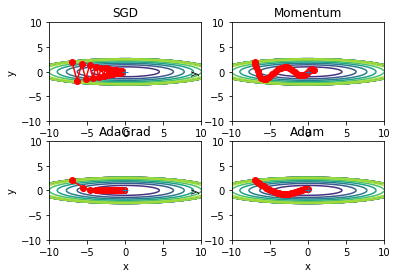

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

모든 문제에서 항상 뛰어난 기법은 없다.

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.2477431147869673
Momentum:2.4446809438198596
AdaGrad:1.84831074518184
Adam:2.2644917321516935
===========iteration:100===========
SGD:1.404307288826712
Momentum:0.3786029154985985
AdaGrad:0.18850832856458916
Adam:0.22424247662815677
===========iteration:200===========
SGD:0.6976693107090255
Momentum:0.23463063004473128
AdaGrad:0.071197082054048
Adam:0.16406776582929683
===========iteration:300===========
SGD:0.5601371441492944
Momentum:0.22896685878276113
AdaGrad:0.14091627608232654
Adam:0.1895103827725236
===========iteration:400===========
SGD:0.3882987811088895
Momentum:0.21036883575961535
AdaGrad:0.09220432691245847
Adam:0.13108425335987606
===========iteration:500===========
SGD:0.3688679425566539
Momentum:0.14688999510149678
AdaGrad:0.09486141322435394
Adam:0.1497160781786004
===========iteration:600===========
SGD:0.26045371825860186
Momentum:0.10768848045971754
AdaGrad:0.04573642920433012
Adam:0.09821706970823432
===========iteration:700=

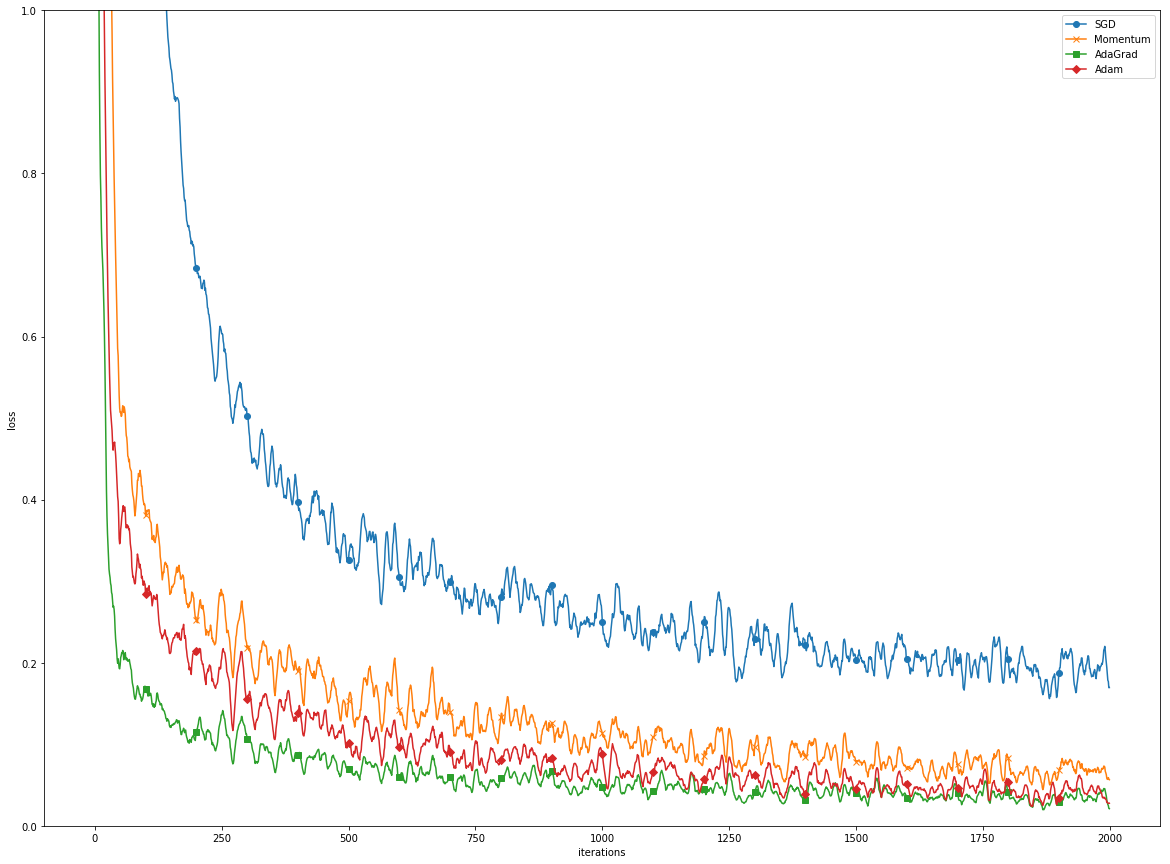

In [3]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.rcParams["figure.figsize"] = (13,13)
plt.show()


## 6.2 가중치의 초깃값  
### 6.2.2 은닉값의 활성화값 분포

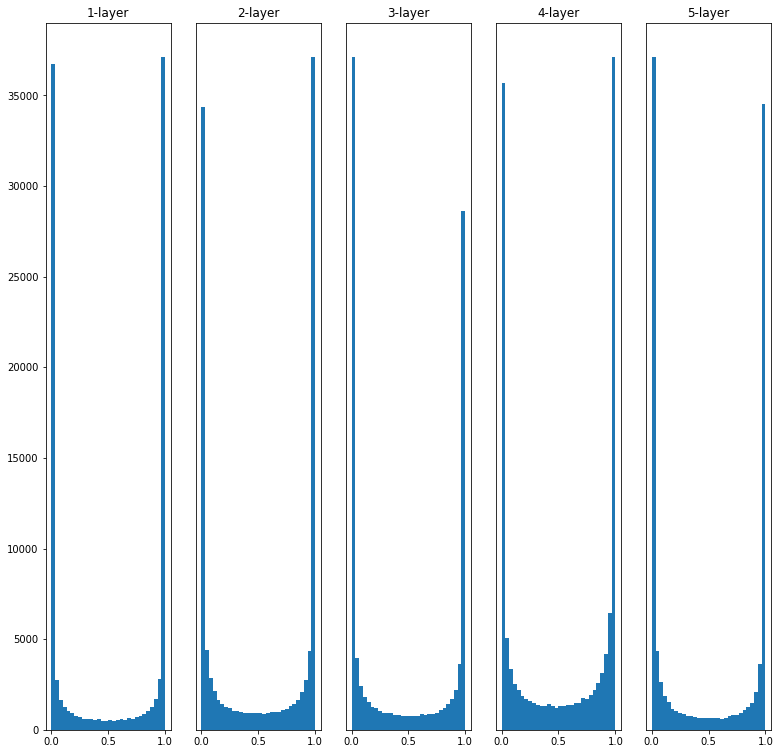

In [4]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

1. 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라짐. **기울기 소실** gradient vanishing
2. 활성화 값들이 치우쳤다는 것은 표현력 관점에서 큰 문제. 표현력을 제한.
3. **Xavier 초깃값** : 각 층의 활성화값들을 광범위하게 분포시킬 목적

<img style="float: left;" src="equations_and_figures/fig%206-12.png" width="450">